In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/data.csv')
print(df.shape)
df.head(2)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
df.drop(['PassengerId', 'Name'], axis=1, inplace=True)
df.shape

(891, 10)

# Target

Survived
0    549
1    342
Name: count, dtype: int64 Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


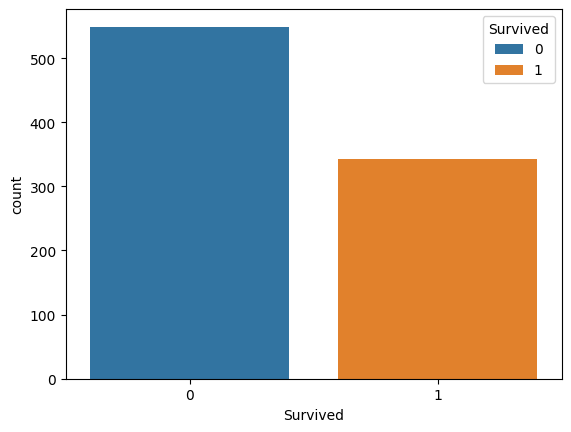

In [4]:
target = 'Survived'

sns.countplot(df, x=target, hue=target)
plt.xlabel('Survived')
print(df[target].value_counts(), df[target].value_counts(normalize=True))

# Var type

In [ ]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
print(len(cat_vars), cat_vars)

In [ ]:
num_vars = [var for var in df.columns if var not in cat_vars and var != target]
print(len(num_vars), num_vars)

# Missing data

In [ ]:
var_with_na = [var for var in df.columns if df[var].isna().sum() > 0]
df[var_with_na].isna().mean().sort_values(ascending=False)

In [ ]:
df[var_with_na].isna().mean().sort_values(ascending=False).plot(kind='bar', figsize=(8, 6))
plt.ylabel('Percentage of Missing Data')
plt.axhline(y=0.7, color='r');

In [ ]:
cat_na = [var for var in cat_vars if var in var_with_na]
num_na = [var for var in num_vars if var in var_with_na]

print('Number of categorical features with na: ', len(cat_na), cat_na)
print('Number of numerical features with na: ', len(num_na), num_na)

# Relationship between na and Target feature

In [ ]:
def analyse_na_value(df, var):
    df = df.copy()
    df[var] = np.where(df[var].isna(), 1, 0)

    tmp = df.groupby(var)[target].agg(['mean', 'std'])
    tmp.plot(kind='barh', y='mean', legend=False,
             xerr='std', title=target, color='green')
    plt.show()

In [ ]:
for var in var_with_na:
    analyse_na_value(df, var)

# Numerical Features

In [ ]:
print(len(num_vars))
df[num_vars].head()

### Discrete Features

In [ ]:
discrete_var = [var for var in num_vars if df[var].nunique() < 20]
print(len(discrete_var))
df[discrete_var].head()

In [ ]:
for var in discrete_var:
    ct = pd.crosstab(df[var], df[target])

    ct.plot(kind='bar', stacked=True)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(f'Counts of {var} Variable Grouped by Target')
    plt.show()

### Continuous Feature

In [ ]:
continuouse_var = [var for var in num_vars if var not in discrete_var]
print(len(continuouse_var))
df[continuouse_var].head()

In [ ]:
sns.pairplot(df[continuouse_var+[target]], hue=target, size=5);

In [ ]:
df[continuouse_var].hist(bins=30, figsize=(10, 5));

In [ ]:
tmp = df.copy()

for var in continuouse_var:
    tmp[var], param = stats.yeojohnson(df[var].fillna(method='bfill'))
tmp[continuouse_var].hist(bins=30, figsize=(10, 5));

In [ ]:
fare = df[['Fare'] + [target]].copy()

bins = [0, 7.9104, 14.4542, 31.0, 512.3292]
labels = ['Low', 'Medium', 'High', 'Very High']

fare['Fare'] = pd.cut(fare['Fare'] , bins=bins, labels=labels, include_lowest=True)

In [ ]:
ct = pd.crosstab(fare['Fare'], fare[target])

ct.plot(kind='bar', stacked=True)
plt.xlabel(var)
plt.ylabel('Count')
plt.title(f'Counts of {var} Variable Grouped by Target')
plt.show()

### Categorical Feature

In [ ]:
print(len(cat_vars))
df[cat_vars].head()

### Number of labels: Cardinality

In [ ]:
cardinalith = df[cat_vars].nunique().sort_values(ascending=False)
print(cardinalith / df.shape[0])
cardinalith.plot.bar();

In [ ]:
df.drop(['Ticket', 'Cabin'], axis=1, inplace=True)
df.shape

In [ ]:
cat_vars = ['Embarked', 'Sex']

for var in cat_vars:
    for target_value in df[target].unique():
        filtered_df = df[df[target] == target_value]
        ct = pd.crosstab(filtered_df[var], filtered_df[target])

        ct.plot(kind='bar', stacked=True)
        plt.xlabel(var)
        plt.ylabel('Count')
        plt.title(f'Counts of {var} for Target = {target_value}')
        plt.show()